# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import os
import cv2   
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image, ImageFile
import matplotlib.pyplot as plt   

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, f1_score, precision_score, 
                             recall_score, classification_report)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


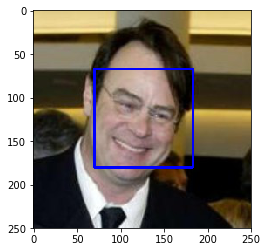

In [3]:
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- Percentage of human faces detected in human images: 98%
- Percentage of human faces detected in dog images: 17%

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short

count = 0
for file in human_files_short:
    if face_detector(file):
        count += 1
print(f'Percentage of human faces detected in human images: {count}')

count = 0
for file in dog_files_short:
    if face_detector(file):
        count += 1
print(f'Percentage of human faces detected in dog images: {count}')

Percentage of human faces detected in human images: 98
Percentage of human faces detected in dog images: 17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
# define VGG16 model
VGG16 = models.vgg16(pretrained = True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 97556218.94it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # read image
    image = Image.open(img_path)
    
    # normalize image
    norm = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    
    # transform image
    loader = transforms.Compose([transforms.Resize(size = (224, 224)),
                                 transforms.ToTensor(),
                                 norm])
    
    transformed_image = loader(image).float()
    
    # set image device as cuda
    if use_cuda:
        transformed_image = transformed_image.unsqueeze(0).cuda()
    
    # get prediction
    pred = VGG16(transformed_image)
    index = torch.max(pred, 1)[1].item()
    
    return index # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    return ((index <= 268) & (index >= 151)) # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- Percentage of dogs detected in human_files_short list of images: 2%
- Percentage of dogs detected in dog_files_short list of images: 100%

In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

count = 0
for file in human_files_short:
    if dog_detector(file):
        count += 1
print(f'Percentage of dogs detected in human images: {count}')

count = 0
for file in dog_files_short:
    if dog_detector(file):
        count += 1
print(f'Percentage of dogs detected in dog images: {count}')

Percentage of dogs detected in human images: 2
Percentage of dogs detected in dog images: 100


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [10]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
BATCH_SIZE = 20
NUM_WORKERS = 0
ImageFile.LOAD_TRUNCATED_IMAGES = True

DATA_DIR = '/data/dog_images/'

TRAIN_PATH = os.path.join(DATA_DIR, 'train')
VAL_PATH = os.path.join(DATA_DIR, 'valid')
TEST_PATH = os.path.join(DATA_DIR, 'test')

In [11]:
# prepare training data
norm = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

train_aug = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(20), 
                                transforms.ToTensor(),
                                norm])

train_ds = datasets.ImageFolder(TRAIN_PATH, train_aug)

# prepare validation data
val_aug = transforms.Compose([transforms.Resize(size = (224, 224)),
                              transforms.ToTensor(),
                              norm])

val_ds = datasets.ImageFolder(VAL_PATH, val_aug)

# prepare test data
test_ds = datasets.ImageFolder(TEST_PATH, val_aug)

# prepare train, validation and test data loaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)

loaders_scratch = {'train': train_loader,
                   'valid': val_loader,
                   'test': test_loader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- I have used image size of 224 x 224 pixels in height and width as most of the ImageNet models use this input image size
- Some data augmentation operations are performed on the training data to avoid overfitting. Image transformations such as random cropping (224 x 224 in size), random horizontal flipping, random rotations are used. 
- For validation and test datasets, no data augmentation is performed
- Images in all three datasets are normalized (stable training, avoids vanishing and exploding gradients)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [12]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3)
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.3)
        self.batch_norm = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(5 * 5 * 512 , 512)
        self.fc2 = nn.Linear(512, 133)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.drop1(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 5 * 5 * 512)
        x = F.relu(self.batch_norm(self.fc1(x)))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
    
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3)
  (drop2): Dropout(p=0.3)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=12800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
- Since there are 133 categories of dog breeds to classify and the number of images per breed is small, we need a deeper CNN model that can extract the important features from the images. But very deep networks trained from scratch on a small dataset tend to overfit the training set and will not generalize well.
- I have built a CNN model that is neither too deep nor too shallow. It has five blocks of Conv2d layer followed by MaxPool2d layer. I added two dropout layers in the model. First dropout layer was added after third block of Conv2d and MaxPool2d layers and second between two fully connected layers to avoid overfitting.
- The two starting blocks of Conv2d and MaxPool2d layers will extract the basic features such as horizontal, vertical and diagonal lines, and corners. The MaxPool2d layer downsamples the feature maps generated by the Conv2d layers by filtering out the most strong activations. These layers also makes the network translational equivariance.
- The deeper blocks of Conv2d layers will combine the basic features to recognize more complex shapes.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.02)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [30]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss reduced ({:.6f} --> {:.6f}). Saving the model'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 
            
    # return trained model
    return model


# train the model
model_scratch = train(15, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.803039 	Validation Loss: 4.786517
Validation loss reduced (inf --> 4.786517). Saving the model
Epoch: 2 	Training Loss: 4.683507 	Validation Loss: 4.666325
Validation loss reduced (4.786517 --> 4.666325). Saving the model
Epoch: 3 	Training Loss: 4.593951 	Validation Loss: 4.587183
Validation loss reduced (4.666325 --> 4.587183). Saving the model
Epoch: 4 	Training Loss: 4.511241 	Validation Loss: 4.383944
Validation loss reduced (4.587183 --> 4.383944). Saving the model
Epoch: 5 	Training Loss: 4.437572 	Validation Loss: 4.509845
Epoch: 6 	Training Loss: 4.353171 	Validation Loss: 4.247968
Validation loss reduced (4.383944 --> 4.247968). Saving the model
Epoch: 7 	Training Loss: 4.278963 	Validation Loss: 4.205240
Validation loss reduced (4.247968 --> 4.205240). Saving the model
Epoch: 8 	Training Loss: 4.213214 	Validation Loss: 4.037421
Validation loss reduced (4.205240 --> 4.037421). Saving the model
Epoch: 9 	Training Loss: 4.147433 	Validation Loss: 4.1

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [31]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim = True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.731071


Test Accuracy: 13% (115/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [21]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

### VGG16 Model

In [56]:
## TODO: Specify model architecture 
vgg_16 = models.vgg16(pretrained = True)
    
print(vgg_16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [57]:
# freeze the pre-trained model weights
for param in vgg_16.parameters():
    param.requires_grad = False
    
vgg_16.classifier[6] = nn.Linear(4096, 133, bias = True)

if use_cuda:
    vgg_16 = vgg_16.cuda()
    
print(vgg_16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
- I have used pre-trained VGG16 model as the first CNN architecture for dog breed classification. The pre-trained weights of the model are freezed so as to protect them from degrading during training. 
- The pre-trained weights of the model were used for feature extraction. The last fully connected layer is trainable and outputs 133 probabilities (one for each dog breed). The model is trained with CrossEntropy loss and SGD optimizer for 5 epochs.
- The performance of this network would be used as the baseline to improve upon. 
- This network is suitable for the current problem as it was trained on ImageNet dataset. The dog breed dataset is similar to the ImageNet dataset and transfer learning is perfectly suitable for this task.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [58]:
# loss function
criterion_transfer = nn.CrossEntropyLoss()

print("Params to learn:")
params_to_update = []
for name, param in vgg_16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [59]:
# optimizer for the model
optimizer_transfer = optim.SGD(params_to_update, lr = 0.001, momentum = 0.9)

# train the model
vgg_16 = train(5, loaders_transfer, vgg_16, 
               optimizer_transfer, criterion_transfer, 
               use_cuda, 'vgg_16.pt')

# load the model that got the best validation accuracy (uncomment the line below)
vgg_16.load_state_dict(torch.load('vgg_16.pt'))

Epoch: 1 	Training Loss: 2.771209 	Validation Loss: 1.003347
Validation loss reduced (inf --> 1.003347). Saving the model
Epoch: 2 	Training Loss: 1.646800 	Validation Loss: 0.730707
Validation loss reduced (1.003347 --> 0.730707). Saving the model
Epoch: 3 	Training Loss: 1.447247 	Validation Loss: 0.627088
Validation loss reduced (0.730707 --> 0.627088). Saving the model
Epoch: 4 	Training Loss: 1.364137 	Validation Loss: 0.578154
Validation loss reduced (0.627088 --> 0.578154). Saving the model
Epoch: 5 	Training Loss: 1.296993 	Validation Loss: 0.583762


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [60]:
test(loaders_transfer, vgg_16, criterion_transfer, use_cuda)

Test Loss: 0.634030


Test Accuracy: 81% (682/836)


### VGG19 Model

In [23]:
# load pre-trained model
vgg_19 = models.vgg19(pretrained = True)

# freeze the pre-trained model weights
for param in vgg_19.parameters():
    param.requires_grad = False
    
vgg_19.classifier[6] = nn.Linear(4096, 133, bias = True)

if use_cuda:
    vgg_19 = vgg_19.cuda()
    
print("Params to learn:")
params_to_update = []
for name, param in vgg_19.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

print(vgg_19)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:06<00:00, 83743672.87it/s]


Params to learn:
	 classifier.6.weight
	 classifier.6.bias
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3,

In [24]:
# optimizer for the model
optimizer_transfer = optim.SGD(params_to_update, lr = 0.001, momentum = 0.9)

# train the model
vgg_19 = train(5, loaders_transfer, vgg_19, 
               optimizer_transfer, criterion_transfer, 
               use_cuda, 'vgg_19.pt')

# load the model that got the best validation accuracy (uncomment the line below)
vgg_19.load_state_dict(torch.load('vgg_19.pt'))

# test the model
test(loaders_transfer, vgg_19, criterion_transfer, use_cuda)

Epoch: 1 	Training Loss: 2.757168 	Validation Loss: 0.988242
Validation loss reduced (inf --> 0.988242). Saving the model
Epoch: 2 	Training Loss: 1.604534 	Validation Loss: 0.710639
Validation loss reduced (0.988242 --> 0.710639). Saving the model
Epoch: 3 	Training Loss: 1.408858 	Validation Loss: 0.618331
Validation loss reduced (0.710639 --> 0.618331). Saving the model
Epoch: 4 	Training Loss: 1.314646 	Validation Loss: 0.567938
Validation loss reduced (0.618331 --> 0.567938). Saving the model
Epoch: 5 	Training Loss: 1.225641 	Validation Loss: 0.532844
Validation loss reduced (0.567938 --> 0.532844). Saving the model
Test Loss: 0.565245


Test Accuracy: 83% (695/836)


- VGG19 model performance is better than VGG16 after training for 5 epochs. VGG16 achieved 81% accuracy while VGG19 achieved 83% accuracy.

### ResNet50 Model

In [28]:
# load pre-trained resnet model
ResNet50 = models.resnet50(pretrained = True)

# freeze the pre-trained model weights
for param in ResNet50.parameters():
    param.requires_grad = False
    
ResNet50.fc = nn.Linear(2048, 133, bias = True)
 
if use_cuda:
    ResNet50 = ResNet50.cuda()
    
print("Params to learn:")
params_to_update = []
for name, param in ResNet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

print(ResNet50)

Params to learn:
	 fc.weight
	 fc.bias
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ke

In [29]:
# optimizer for the model
optimizer_transfer = optim.SGD(params_to_update, lr = 0.001, momentum = 0.9)

# train the model
ResNet50 = train(5, loaders_transfer, ResNet50, 
                 optimizer_transfer, criterion_transfer, 
                 use_cuda, 'ResNet50.pt')

# load the model that got the best validation accuracy (uncomment the line below)
ResNet50.load_state_dict(torch.load('ResNet50.pt'))

# test the model
test(loaders_transfer, ResNet50, criterion_transfer, use_cuda)

Epoch: 1 	Training Loss: 4.270513 	Validation Loss: 3.213966
Validation loss reduced (inf --> 3.213966). Saving the model
Epoch: 2 	Training Loss: 3.124852 	Validation Loss: 2.197053
Validation loss reduced (3.213966 --> 2.197053). Saving the model
Epoch: 3 	Training Loss: 2.445501 	Validation Loss: 1.623990
Validation loss reduced (2.197053 --> 1.623990). Saving the model
Epoch: 4 	Training Loss: 2.070387 	Validation Loss: 1.329494
Validation loss reduced (1.623990 --> 1.329494). Saving the model
Epoch: 5 	Training Loss: 1.823125 	Validation Loss: 1.154891
Validation loss reduced (1.329494 --> 1.154891). Saving the model
Test Loss: 1.131310


Test Accuracy: 76% (637/836)


In [30]:
# train the model
ResNet50 = train(5, loaders_transfer, ResNet50, 
                 optimizer_transfer, criterion_transfer, 
                 use_cuda, 'ResNet50.pt')

# load the model that got the best validation accuracy (uncomment the line below)
ResNet50.load_state_dict(torch.load('ResNet50.pt'))

# test the model
test(loaders_transfer, ResNet50, criterion_transfer, use_cuda)

Epoch: 1 	Training Loss: 1.674863 	Validation Loss: 1.051458
Validation loss reduced (inf --> 1.051458). Saving the model
Epoch: 2 	Training Loss: 1.573788 	Validation Loss: 0.930600
Validation loss reduced (1.051458 --> 0.930600). Saving the model
Epoch: 3 	Training Loss: 1.473166 	Validation Loss: 0.837313
Validation loss reduced (0.930600 --> 0.837313). Saving the model
Epoch: 4 	Training Loss: 1.413596 	Validation Loss: 0.807391
Validation loss reduced (0.837313 --> 0.807391). Saving the model
Epoch: 5 	Training Loss: 1.337612 	Validation Loss: 0.795224
Validation loss reduced (0.807391 --> 0.795224). Saving the model
Test Loss: 0.771531


Test Accuracy: 82% (688/836)


### DenseNet121 Model

In [37]:
# load pre-trained DenseNet121 model
DenseNet121 = models.densenet121(pretrained = True)

# freeze the pre-trained model weights
for param in DenseNet121.parameters():
    param.requires_grad = False
    
DenseNet121.classifier = nn.Linear(1024, 133, bias = True)
   
if use_cuda:
    DenseNet121 = DenseNet121.cuda()
    
print("Params to learn:")
params_to_update = []
for name, param in DenseNet121.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

print(DenseNet121)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Params to learn:
	 classifier.weight
	 classifier.bias
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True,

In [38]:
# optimizer for the model
optimizer_transfer = optim.SGD(params_to_update, lr = 0.001, momentum = 0.9)

# train the model
DenseNet121 = train(7, loaders_transfer, DenseNet121, 
                    optimizer_transfer, criterion_transfer, 
                    use_cuda, 'DenseNet121.pt')

# load the model that got the best validation accuracy (uncomment the line below)
DenseNet121.load_state_dict(torch.load('DenseNet121.pt'))

# test the model
test(loaders_transfer, DenseNet121, criterion_transfer, use_cuda)

Epoch: 1 	Training Loss: 4.243626 	Validation Loss: 3.288592
Validation loss reduced (inf --> 3.288592). Saving the model
Epoch: 2 	Training Loss: 3.073196 	Validation Loss: 2.314056
Validation loss reduced (3.288592 --> 2.314056). Saving the model
Epoch: 3 	Training Loss: 2.456363 	Validation Loss: 1.710766
Validation loss reduced (2.314056 --> 1.710766). Saving the model
Epoch: 4 	Training Loss: 2.074838 	Validation Loss: 1.455094
Validation loss reduced (1.710766 --> 1.455094). Saving the model
Epoch: 5 	Training Loss: 1.849029 	Validation Loss: 1.246276
Validation loss reduced (1.455094 --> 1.246276). Saving the model
Epoch: 6 	Training Loss: 1.677830 	Validation Loss: 1.110960
Validation loss reduced (1.246276 --> 1.110960). Saving the model
Epoch: 7 	Training Loss: 1.554157 	Validation Loss: 1.036300
Validation loss reduced (1.110960 --> 1.036300). Saving the model
Test Loss: 1.054336


Test Accuracy: 77% (651/836)


In [39]:
# train the model
DenseNet121 = train(5, loaders_transfer, DenseNet121, 
                    optimizer_transfer, criterion_transfer, 
                    use_cuda, 'DenseNet121.pt')

# load the model that got the best validation accuracy (uncomment the line below)
DenseNet121.load_state_dict(torch.load('DenseNet121.pt'))

# test the model
test(loaders_transfer, DenseNet121, criterion_transfer, use_cuda)

Epoch: 1 	Training Loss: 1.494687 	Validation Loss: 0.954422
Validation loss reduced (inf --> 0.954422). Saving the model
Epoch: 2 	Training Loss: 1.448714 	Validation Loss: 0.877808
Validation loss reduced (0.954422 --> 0.877808). Saving the model
Epoch: 3 	Training Loss: 1.370479 	Validation Loss: 0.857804
Validation loss reduced (0.877808 --> 0.857804). Saving the model
Epoch: 4 	Training Loss: 1.298796 	Validation Loss: 0.846464
Validation loss reduced (0.857804 --> 0.846464). Saving the model
Epoch: 5 	Training Loss: 1.293088 	Validation Loss: 0.789516
Validation loss reduced (0.846464 --> 0.789516). Saving the model
Test Loss: 0.814317


Test Accuracy: 80% (670/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [42]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path)
    
    norm = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    
    loader = transforms.Compose([transforms.Resize(size = (224, 224)),
                                 transforms.ToTensor(),
                                 norm])
    
    transformed_image = loader(image).float()
    
    if use_cuda:
        transformed_image = transformed_image.unsqueeze(0).cuda()
        
    pred = vgg_19(transformed_image)
    index = torch.max(pred, 1)[1].item()
    return class_names[index]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [47]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def show_image(img_path):
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path):
        print('Hello! You look like a ...')
        breed = predict_breed_transfer(img_path)
        print('Predicted breed:', breed)
        show_image(img_path)
        
    elif dog_detector(img_path):
        print('This dog breed is ...')
        breed = predict_breed_transfer(img_path)
        print('Predicted breed:', breed)
        show_image(img_path)
        
    else:
        print('Invalid image')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
- The output is not as good as I expected. This is because the number of classes in the dataset is very large and the number of images per class is small. The accuracy of the final model on the test dataset is 83%. This is not a good classification accuracy. Deep learning models are capable of achieving accuracies > 95% very easily when provided with enough data.
- In order to improve the performance of the dog breed prediction model we can do the following things:
    1. Get more number of images per class
    2. Make the dataset balanced
    3. Use image augmentation methods such as CutOut, MixUp and CutMix
    4. Use VAEs/GANs to generate artificial data
    5. Use more efficient algorithms such as EfficientNet
    6. Use activation maps to interpret the model

Hello! You look like a ...
Predicted breed: Pharaoh hound


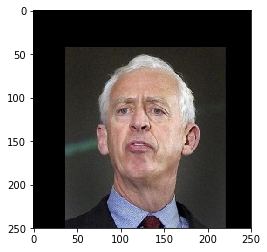

Hello! You look like a ...
Predicted breed: Bull terrier


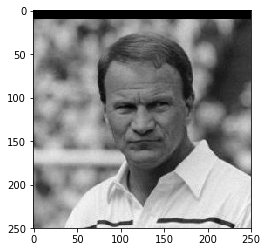

Hello! You look like a ...
Predicted breed: Smooth fox terrier


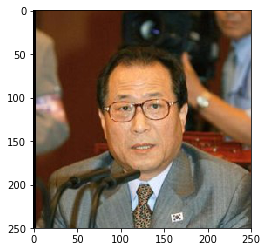

Hello! You look like a ...
Predicted breed: Basenji


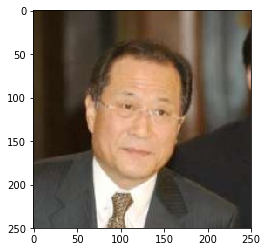

This dog breed is ...
Predicted breed: Mastiff


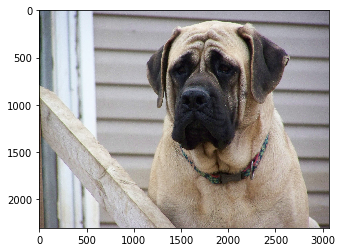

This dog breed is ...
Predicted breed: Bullmastiff


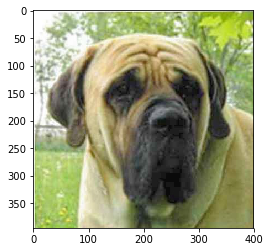

This dog breed is ...
Predicted breed: Mastiff


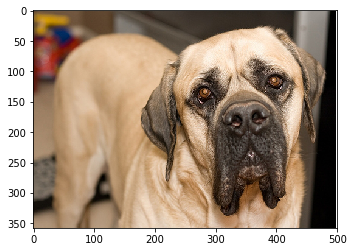

This dog breed is ...
Predicted breed: Mastiff


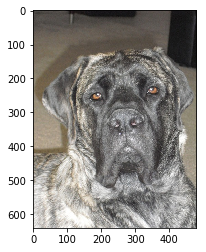

In [51]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[3:7], dog_files[3:7])):
    run_app(file)